# 13.1 Backtesting
I will try out a popular strategy using the IBS indicator. I want to see if I can match the results on [here](https://www.quantifiedstrategies.com/internal-bar-strength-ibs-indicator-strategy/). I will also use pure pandas.

* Universe: SPY ETF
* Entry: IBS < 0.2
* Exit: IBS > 0.8
* Trading on close prices.

In [8]:
from utils import get_data, get_id, last_trading_date_before_equal, get_market_dates, first_trading_date_after
from scipy import stats
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [ ]:
daily = get_data(get_id("SPY"), columns=['open', 'high', 'low', 'close'])

# Calculate indicator and signals
daily['IBS'] = (daily.close - daily.low) / (daily.high - daily.low)
conditions = [daily['IBS'] <= 0.2, daily['IBS'] >= 0.8]
choices = [1, 0]
daily['signal_eod'] = np.select(conditions, choices, default=np.nan)
daily['signal_eod'] = daily['signal_eod'].ffill()

# Calculate strategy results
daily['return'] = daily.close.pct_change()
daily['strategy_return'] = daily['signal_eod'].shift(1) * daily['return']
daily['strategy_cumulative_return'] = (1 + daily['strategy_return']).cumprod() - 1
daily['strategy_capital'] = (daily['strategy_cumulative_return'] + 1)*10000

In [ ]:
daily.drop(columns=['open', 'high', 'low']).head(3)

,close,IBS,signal_eod,return,strategy_return,strategy_cumulative_return,strategy_capital
datetime,,,,,,,
2019-01-02,232.385259,0.819392,0.0,NaN,NaN,NaN,NaN
2019-01-03,226.693092,0.093878,1.0,-0.024495,-0.000000,0.000000,10000.000000
2019-01-04,234.437410,0.892256,0.0,0.034162,0.034162,0.034162,10341.621267


In [ ]:
daily.drop(columns=['open', 'high', 'low']).tail(3)

,close,IBS,signal_eod,return,strategy_return,strategy_cumulative_return,strategy_capital
datetime,,,,,,,
2023-09-05,449.25,0.042328,1.0,-0.004344,-0.004344,1.811365,28113.646265
2023-09-06,446.19,0.506383,1.0,-0.006811,-0.006811,1.792215,27922.154317
2023-09-07,444.84,0.746429,1.0,-0.003026,-0.003026,1.783767,27837.672575


Text(0.5, 1.0, 'IBS strategy')

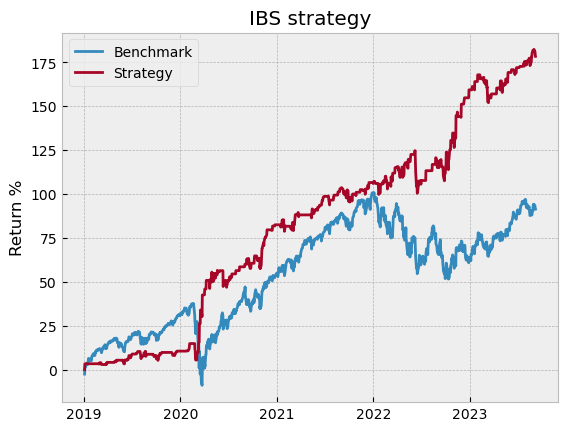

In [ ]:
# Plot performance
plt.style.use('bmh')
fig, ax = plt.subplots()
ax.plot(daily.index, ((1 + daily['return']).cumprod() - 1)*100, label='Benchmark')
ax.plot(daily.index, daily.strategy_cumulative_return * 100, label='Strategy')
ax.legend()
ax.set_ylabel('Return %')
ax.set_title('IBS strategy')

**Strategy analysis**

Now that we have the results, we want more statistics. The calculate them we either need a return series or a trade log. To get the trade log, we infer it from the DataFrames above. However in an event-driven backtester the trade log is built trade-by-trade just as in 'real life'. Now a list of statistics of interest follow. 

* Annual return
* Sharpe
* Sortina
* Alpha
* Beta
* Winning months
* Time in market
* Transaction costs/year
* Average profit/trade
* Average duration
* Profit factor
* Win rate
* Trades/month

**Charts**
* Returns
* Drawdown
* (Bar chart) return per month

I would trade a strategy if:
* It has a zero-leverage annual return above 10%
* Has a average-per-trade profit of higher than 0.3%. A too low average profit means high sensitivity to trading fees and I don't like that.
* Trades frequently. More than 5x/month is acceptable.
* Max drawdown lower than 25%. 

Bonus points if:
* Negative correlation with other strategies, especially the stock index. A 'crisis-alpha' strategy is worth a lot, if in normal times the return is higher than the risk-free rate.
* Easily leverageable. This is the case with e.g. SPY, but not so much with small-caps.
* Low exposure. This means that the remaining capital can be invested in other strategies or even the risk-free rate.

I don't care at all about (unless it is in the extremes):
* Win rate
* Profit factor

**Statistics calculated using returns only**

All inputs are cumulative returns.

In [ ]:
daily['cumulative_return'] = (daily['return'] + 1).cumprod() - 1

In [ ]:
def calculate_annual_return(returns):
    cum_returns_gross = (returns + 1).cumprod() - 1
    total_length = returns.index[-1] - returns.index[0]
    annual_return = (cum_returns_gross[-1])**(1/(total_length.days/365)) - 1
    return round(annual_return, 3)

In [ ]:
annual_return = calculate_annual_return(daily['strategy_return'])
print(annual_return)

0.132


In [ ]:
def calculate_sortina(returns, risk_free = 0):
    annual_mean = returns.mean()*252 - risk_free
    annual_downward_std = returns[returns < 0].std()*np.sqrt(252)
    return round(annual_mean/annual_downward_std, 2)

In [ ]:
def calculate_sharpe(returns, risk_free = 0):
    annual_mean = returns.mean()*252 - risk_free
    annual_downward_std = returns.std()*np.sqrt(252)
    return round(annual_mean/annual_downward_std, 2)

In [ ]:
sortina = calculate_sortina(daily['strategy_return'])
sharpe = calculate_sharpe(daily['strategy_return'])
print(calculate_sortina(daily['strategy_return']))
print(calculate_sortina(daily['return']))
print()
print(calculate_sharpe(daily['strategy_return']))
print(calculate_sharpe(daily['return']))

1.57
0.91

1.63
0.75


In [ ]:
def calculate_alpha_beta(returns, returns_benchmark, risk_free = 0):
    returns = returns - risk_free/252
    returns_benchmark = returns_benchmark - risk_free/252
    beta, alpha = stats.linregress(returns_benchmark.dropna().values,
                returns.dropna().values)[0:2]
    return round(alpha, 2), round(beta, 2)

In [ ]:
def calculate_alpha_beta_weekly(returns, returns_benchmark, risk_free = 0):
    returns = returns - risk_free/52
    returns = returns.resample('1W').last()

    returns_benchmark = returns_benchmark - risk_free/52
    returns_benchmark = returns_benchmark.resample('1W').last()

    beta, alpha = stats.linregress(returns_benchmark.dropna().values,
                returns.dropna().values)[0:2]
    return round(alpha, 2), round(beta, 2)

In [ ]:
alpha, beta = calculate_alpha_beta(daily['strategy_return'], daily['return'])
print(alpha)
print(beta)

0.0
0.42


In [ ]:
# The alpha/beta can be misleading! The reason there is no alpha is because the strategy either is 100% invested in the benchmark of zero. Even if a strategy only picks the positive days, the alpha will be zero, because the beta will simply be scaled by a fraction that depends on the amount of positive days. On days where the strategy is in the index, the beta is 1. Else it is 0. Aggregating to higher timeframes does not solve this problem apparently.
daily['perfect_strategy_returns'] = np.where(daily['return'] > 0, daily['return'], 0)
daily['perfect_strategy_returns_cumulative'] = (daily['perfect_strategy_returns'] + 1).cumprod() - 1
calculate_alpha_beta(daily['perfect_strategy_returns'][2:], daily['return'][2:])

(0.0, 0.48)

In [ ]:
def calculate_drawdowns(returns):
    """
    Get drawdown Series, maximum DD and maximum duration
    cum_returns - Returns of strategy from the beginning
    """
    cum_returns = (returns + 1).cumprod() - 1
    cum_returns_gross= cum_returns + 1
    maximum_gross_return = cum_returns_gross.cummax()
    drawdown = (1-cum_returns_gross/maximum_gross_return)

    ATH_series = drawdown[drawdown == 0]
    durations = (
        ATH_series.index[1:].to_pydatetime() - ATH_series.index[:-1].to_pydatetime()
    )

    return -drawdown, round(-drawdown.max(), 3), durations.max()

In [ ]:
drawdowns, max_dd, max_dd_duration = calculate_drawdowns(daily['strategy_return'])
print(max_dd)
print(max_dd_duration)

-0.108
131 days, 0:00:00


**Inferring the trade log**

A "trade" is a "fill". This is different from an order, which is not guaranteed to be filled. A fill will have the following properties: datetime, symbol, quantity, price. This does not contain the 'exit price', which has to be inferred. The exit may even be partial. I will create two logs: a fill log and a trade log. The fill log is simply the list of fills. The trade log uses the fill log to determine what the entry/exit prices of a round-trip trade would have been. A trade log can always be inferred from a list of fills. 

In [ ]:
fill_log = daily[['close', 'signal_eod']].copy()
fill_log['buy_or_sell'] = fill_log['signal_eod'].diff()
fill_log = fill_log[fill_log['buy_or_sell'] != 0].dropna()
fill_log = fill_log.drop(columns=['signal_eod'])

In [ ]:
# A 1 on 'signal_eod_diff' means a buy. A -1 a sell. The price at which the buy/sell occurs is the close price. We do not need to shift down here.
fill_log.head(5)

,close,buy_or_sell
datetime,,
2019-01-03,226.693092,1.0
2019-01-04,234.437410,-1.0
2019-02-25,259.601801,1.0
2019-02-27,259.286086,-1.0
2019-02-28,258.645369,1.0


In [ ]:
# Let's assume that we just always buy only 1 unit for simplicity. In the 'real backtester' I would calculate the positions by dividing the portfolio balance by the price. 
trades = {} # {date_in: [qty_in, price_in, date_out, qty_out, price_out, profit], ...}
for day, trade in fill_log.iterrows():
    datestring = day.to_pydatetime().date().isoformat()
    price = round(trade['close'], 2)
    direction = trade['buy_or_sell']
    quantity = abs(trade['buy_or_sell'])
    if direction == 1:
        trades[datestring] = [quantity, price, np.nan, np.nan, np.nan, np.nan]
    elif direction == -1:
        # The correct way would be to search for the first trade with the same symbol that has not yet been closed. But then a dictionary won't work. And partial fills will increase the complexity even more...
        # Here we just take the last trade.
        trades[list(trades.keys())[-1]][2] = datestring
        trades[list(trades.keys())[-1]][3] = quantity
        trades[list(trades.keys())[-1]][4] = price

In [ ]:
list(trades.items())[:5]

[('2019-01-03', [1.0, 226.69, '2019-01-04', 1.0, 234.44, nan]),
 ('2019-02-25', [1.0, 259.6, '2019-02-27', 1.0, 259.29, nan]),
 ('2019-02-28', [1.0, 258.65, '2019-03-01', 1.0, 260.46, nan]),
 ('2019-03-06', [1.0, 257.49, '2019-03-08', 1.0, 254.92, nan]),
 ('2019-03-22', [1.0, 260.45, '2019-03-29', 1.0, 263.59, nan])]

In [ ]:
trade_log = pd.DataFrame.from_dict(trades, orient='index', columns=['qty_in', 'price_in', 'date_out', 'qty_out', 'price_out', 'profit'])
trade_log['profit'] = trade_log['qty_out']*trade_log['price_out'] - trade_log['qty_in']*trade_log['price_in']
trade_log.dropna(inplace=True)

In [ ]:
trade_log.head(5)

,qty_in,price_in,date_out,qty_out,price_out,profit
2019-01-03,1.0,226.69,2019-01-04,1.0,234.44,7.75
2019-02-25,1.0,259.60,2019-02-27,1.0,259.29,-0.31
2019-02-28,1.0,258.65,2019-03-01,1.0,260.46,1.81
2019-03-06,1.0,257.49,2019-03-08,1.0,254.92,-2.57
2019-03-22,1.0,260.45,2019-03-29,1.0,263.59,3.14


**Statistics calculated using the fill or trade log**

In [ ]:
trade_log['time_in_market'] = pd.to_datetime(trade_log['date_out']) - pd.to_datetime(trade_log.index)
time_in_market = trade_log['time_in_market'].sum().days # Technically incorrect because it also counts non-trading days
time_in_market

584

In [ ]:
average_time_in_trade = round(time_in_market/len(trade_log), 1)
average_time_in_trade

3.9

In [ ]:
fill_log['transaction_costs'] = fill_log['buy_or_sell'].abs()*fill_log['close']*0.001
total_transaction_costs = fill_log['transaction_costs'].sum()
round(total_transaction_costs, 2)

108.02

In [ ]:
# To get it per year, you have to calculate the transaction costs per year and then divide it by the ending capital. For that I need to keep track of the capital, which I have skipped.

In [ ]:
average_profit_per_trade = round(trade_log['profit'].mean(), 2)
average_profit_per_trade

2.29

In [ ]:
amount_of_trades = len(fill_log)
amount_of_trades

297

In [ ]:
months = (daily.index[-1] - daily.index[0]).days/30
trades_per_month = round(amount_of_trades/months, 1)
trades_per_month

5.2

In [ ]:
average_profit = trade_log[trade_log['profit'] > 0]['profit'].mean()
average_loss = abs(trade_log[trade_log['profit'] < 0]['profit'].mean())
profit_factor = round(average_profit/average_loss, 2)
profit_factor

1.02

In [ ]:
number_of_profits = trade_log[trade_log['profit'] > 0]['profit'].count()
win_rate = round(number_of_profits/len(trade_log), 2)
win_rate

0.7

In [ ]:
monthly_return = daily['strategy_return'].resample('1M').sum()
winning_months = round(monthly_return[monthly_return > 0].count() / len(monthly_return), 1)
winning_months

0.7

**All stats**

In [ ]:
statistics = {'Annual return': annual_return,
              'Sharpe': sharpe,
              'Sortina': sortina,
              'Alpha': alpha,
              'Beta': beta,
              'Winning months': winning_months,
              'Exposure': time_in_market,
              'Average profit': average_profit_per_trade,
              'Average time/trade': average_time_in_trade,
              'Profit factor': profit_factor,
              'Winrate': win_rate,
              'Trades/month': trades_per_month}
statistics

{'Annual return': 0.132,
 'Sharpe': 1.63,
 'Sortina': 1.57,
 'Alpha': 0.0,
 'Beta': 0.42,
 'Winning months': 0.7,
 'Exposure': 584,
 'Average profit': 2.29,
 'Average time/trade': 3.9,
 'Profit factor': 1.02,
 'Winrate': 0.7,
 'Trades/month': 5.2}

**Plots**

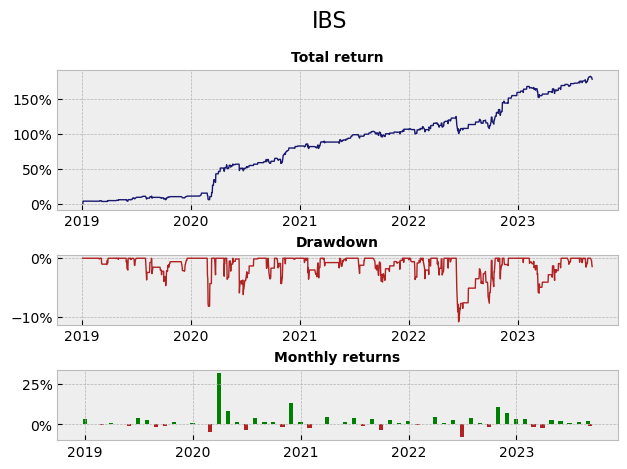

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle('IBS',fontsize=16)
fig.tight_layout(pad=1.5)

# Returns
ax1.plot(daily.index, daily["strategy_cumulative_return"]*100, color="midnightblue", linewidth=1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax1.set_title('Total return', fontsize=10, fontweight='bold')

# Drawdown
ax2.plot(drawdowns.index, drawdowns*100, color="firebrick", linewidth=1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax2.set_title('Drawdown', fontsize=10, fontweight='bold')

# Monthly returns
monthly_return = daily['strategy_return'].resample('1M').sum()
colors = ['firebrick' if ret < 0 else 'g' for ret in monthly_return]
monthly_return_index = monthly_return.index.values
monthly_return_index[0] = daily.index[0] # To make the x-axis align
monthly_return_index[-1] = daily.index[-1] # To make the x-axis align

ax3.bar(monthly_return.index, monthly_return.values*100, width=15, color=colors)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax3.set_title('Monthly returns', fontsize=10, fontweight='bold')

plt.show()

In [1]:
import json
DATA_PATH = "../data/polygon/"

def get_top_n_liquid(day, n=500):
    with open(DATA_PATH + f'processed/cache/top_{n}_liquid.json', 'r') as f:
        data = json.load(f)

    dates = list(data.keys())
    date_to_query = max(list(filter(lambda x: x <= day.isoformat(), dates)) )
    return date_to_query, data[date_to_query]

In [30]:
# Get the start and end trading dates in a quarter
quarter_start = [date(2019, 1, 1)]
quarter_end = []
for day in pd.date_range(date(2019, 1, 1), date(2023, 9, 1), freq='Q'):
    day = day.to_pydatetime().date()
    quarter_end.append(last_trading_date_before_equal(day))
    quarter_start.append(first_trading_date_after(last_trading_date_before_equal(day)))
quarter_start = [day for day in quarter_start if day < quarter_end[-1]] # Filter such that no start dates are after the end dates

In [32]:
# Loop over all quarters, aggregate and average.
for date_start, date_end in zip(quarter_start, quarter_end):
    print(f"{date_start} to {date_end}")

2019-01-01 to 2019-03-29
2019-04-01 to 2019-06-28
2019-07-01 to 2019-09-30
2019-10-01 to 2019-12-31
2020-01-02 to 2020-03-31
2020-04-01 to 2020-06-30
2020-07-01 to 2020-09-30
2020-10-01 to 2020-12-31
2021-01-04 to 2021-03-31
2021-04-01 to 2021-06-30
2021-07-01 to 2021-09-30
2021-10-01 to 2021-12-31
2022-01-03 to 2022-03-31
2022-04-01 to 2022-06-30
2022-07-01 to 2022-09-30
2022-10-03 to 2022-12-30
2023-01-03 to 2023-03-31
2023-04-03 to 2023-06-30
